In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# importing liberaries 
import missingno as msno 
import matplotlib.pyplot as plt 
import pandas as pd
from sqlalchemy import create_engine
import sys 
import os 
import numpy as np 
import seaborn as sns 
import sys, os
import sklearn
from sklearn.decomposition import PCA
import logging
from scipy.stats.mstats import winsorize


current_directory = os.getcwd()
parent_directory = os.path.abspath(os.path.join(current_directory, '..'))

if parent_directory not in sys.path:
    sys.path.insert(0, parent_directory)


from src.utils import percent_missing, format_float, find_agg, missing_values_table,convert_bytes_to_megabytes,fix_missing_ffill,fix_missing_bfill



database_name = 'tcom'
table_name= 'xdr_data'

connection_params = { "host": "localhost", "user": "postgres", "password": "1234",
                    "port": "5432", "database": database_name}

engine = create_engine(f"postgresql+psycopg2://{connection_params['user']}:{connection_params['password']}@{connection_params['host']}:{connection_params['port']}/{connection_params['database']}")

# str or SQLAlchemy Selectable (select or text object)
sql_query = 'SELECT * FROM xdr_data'

df = pd.read_sql(sql_query, con= engine)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Analyzing dataframe

In [4]:
# visualize 5 rows to understand the data better 
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [5]:
df.columns


Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


In [6]:


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 149010 non-null  float64
 1   Start                                     150000 non-null  object 
 2   Start ms                                  150000 non-null  float64
 3   End                                       150000 non-null  object 
 4   End ms                                    150000 non-null  float64
 5   Dur. (ms)                                 150000 non-null  float64
 6   IMSI                                      149431 non-null  float64
 7   MSISDN/Number                             148935 non-null  float64
 8   IMEI                                      149429 non-null  float64
 9   Last Location Name                        148848 non-null  object 
 10  Avg RTT DL (ms)     

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Bearer Id,149010.0,1.013887e+19,2.893173e+18,6.917538e+18,7.349883e+18,7.349883e+18,1.304243e+19,1.318654e+19
Start ms,150000.0,4.991882e+02,2.886118e+02,0.000000e+00,2.500000e+02,4.990000e+02,7.490000e+02,9.990000e+02
End ms,150000.0,4.988009e+02,2.880977e+02,0.000000e+00,2.510000e+02,5.000000e+02,7.500000e+02,9.990000e+02
Dur. (ms),150000.0,1.046086e+05,8.103762e+04,7.142000e+03,5.744050e+04,8.639900e+04,1.324302e+05,1.859336e+06
IMSI,149431.0,2.082016e+14,2.148809e+10,2.040471e+14,2.082014e+14,2.082015e+14,2.082018e+14,2.140743e+14
MSISDN/Number,148935.0,4.188282e+10,2.447443e+12,3.360100e+10,3.365130e+10,3.366371e+10,3.368349e+10,8.823971e+14
IMEI,149429.0,4.847455e+13,2.241637e+13,4.400152e+11,3.546071e+13,3.572201e+13,8.611970e+13,9.900120e+13
Avg RTT DL (ms),122172.0,1.097957e+02,6.197827e+02,0.000000e+00,3.200000e+01,4.500000e+01,7.000000e+01,9.692300e+04
Avg RTT UL (ms),122189.0,1.766288e+01,8.479352e+01,0.000000e+00,2.000000e+00,5.000000e+00,1.500000e+01,7.120000e+03
Avg Bearer TP DL (kbps),150000.0,1.330005e+04,2.397188e+04,0.000000e+00,4.300000e+01,6.300000e+01,1.971075e+04,3.781600e+05


In [8]:
df.shape

(150001, 55)

# preprocessing data 

In [9]:
df.isnull().sum()

Bearer Id                                      991
Start                                            1
Start ms                                         1
End                                              1
End ms                                           1
Dur. (ms)                                        1
IMSI                                           570
MSISDN/Number                                 1066
IMEI                                           572
Last Location Name                            1153
Avg RTT DL (ms)                              27829
Avg RTT UL (ms)                              27812
Avg Bearer TP DL (kbps)                          1
Avg Bearer TP UL (kbps)                          1
TCP DL Retrans. Vol (Bytes)                  88146
TCP UL Retrans. Vol (Bytes)                  96649
DL TP < 50 Kbps (%)                            754
50 Kbps < DL TP < 250 Kbps (%)                 754
250 Kbps < DL TP < 1 Mbps (%)                  754
DL TP > 1 Mbps (%)             

In [10]:
# fetch colums which has missing value 
columns = []
counts=[]
i=0
for key, item in df.isnull().sum().items():
    if item != 0:
        columns.append(key)
        counts.append(item)
        i+=1
print('the dataset has {} columns with missing values'.format(i))
pd.DataFrame({'column name':columns,'counts':counts})

the dataset has 41 columns with missing values


,column name,counts
0,Bearer Id,991
1,Start,1
2,Start ms,1
3,End,1
4,End ms,1
5,Dur. (ms),1
6,IMSI,570
7,MSISDN/Number,1066
8,IMEI,572
9,Last Location Name,1153


<AxesSubplot:>

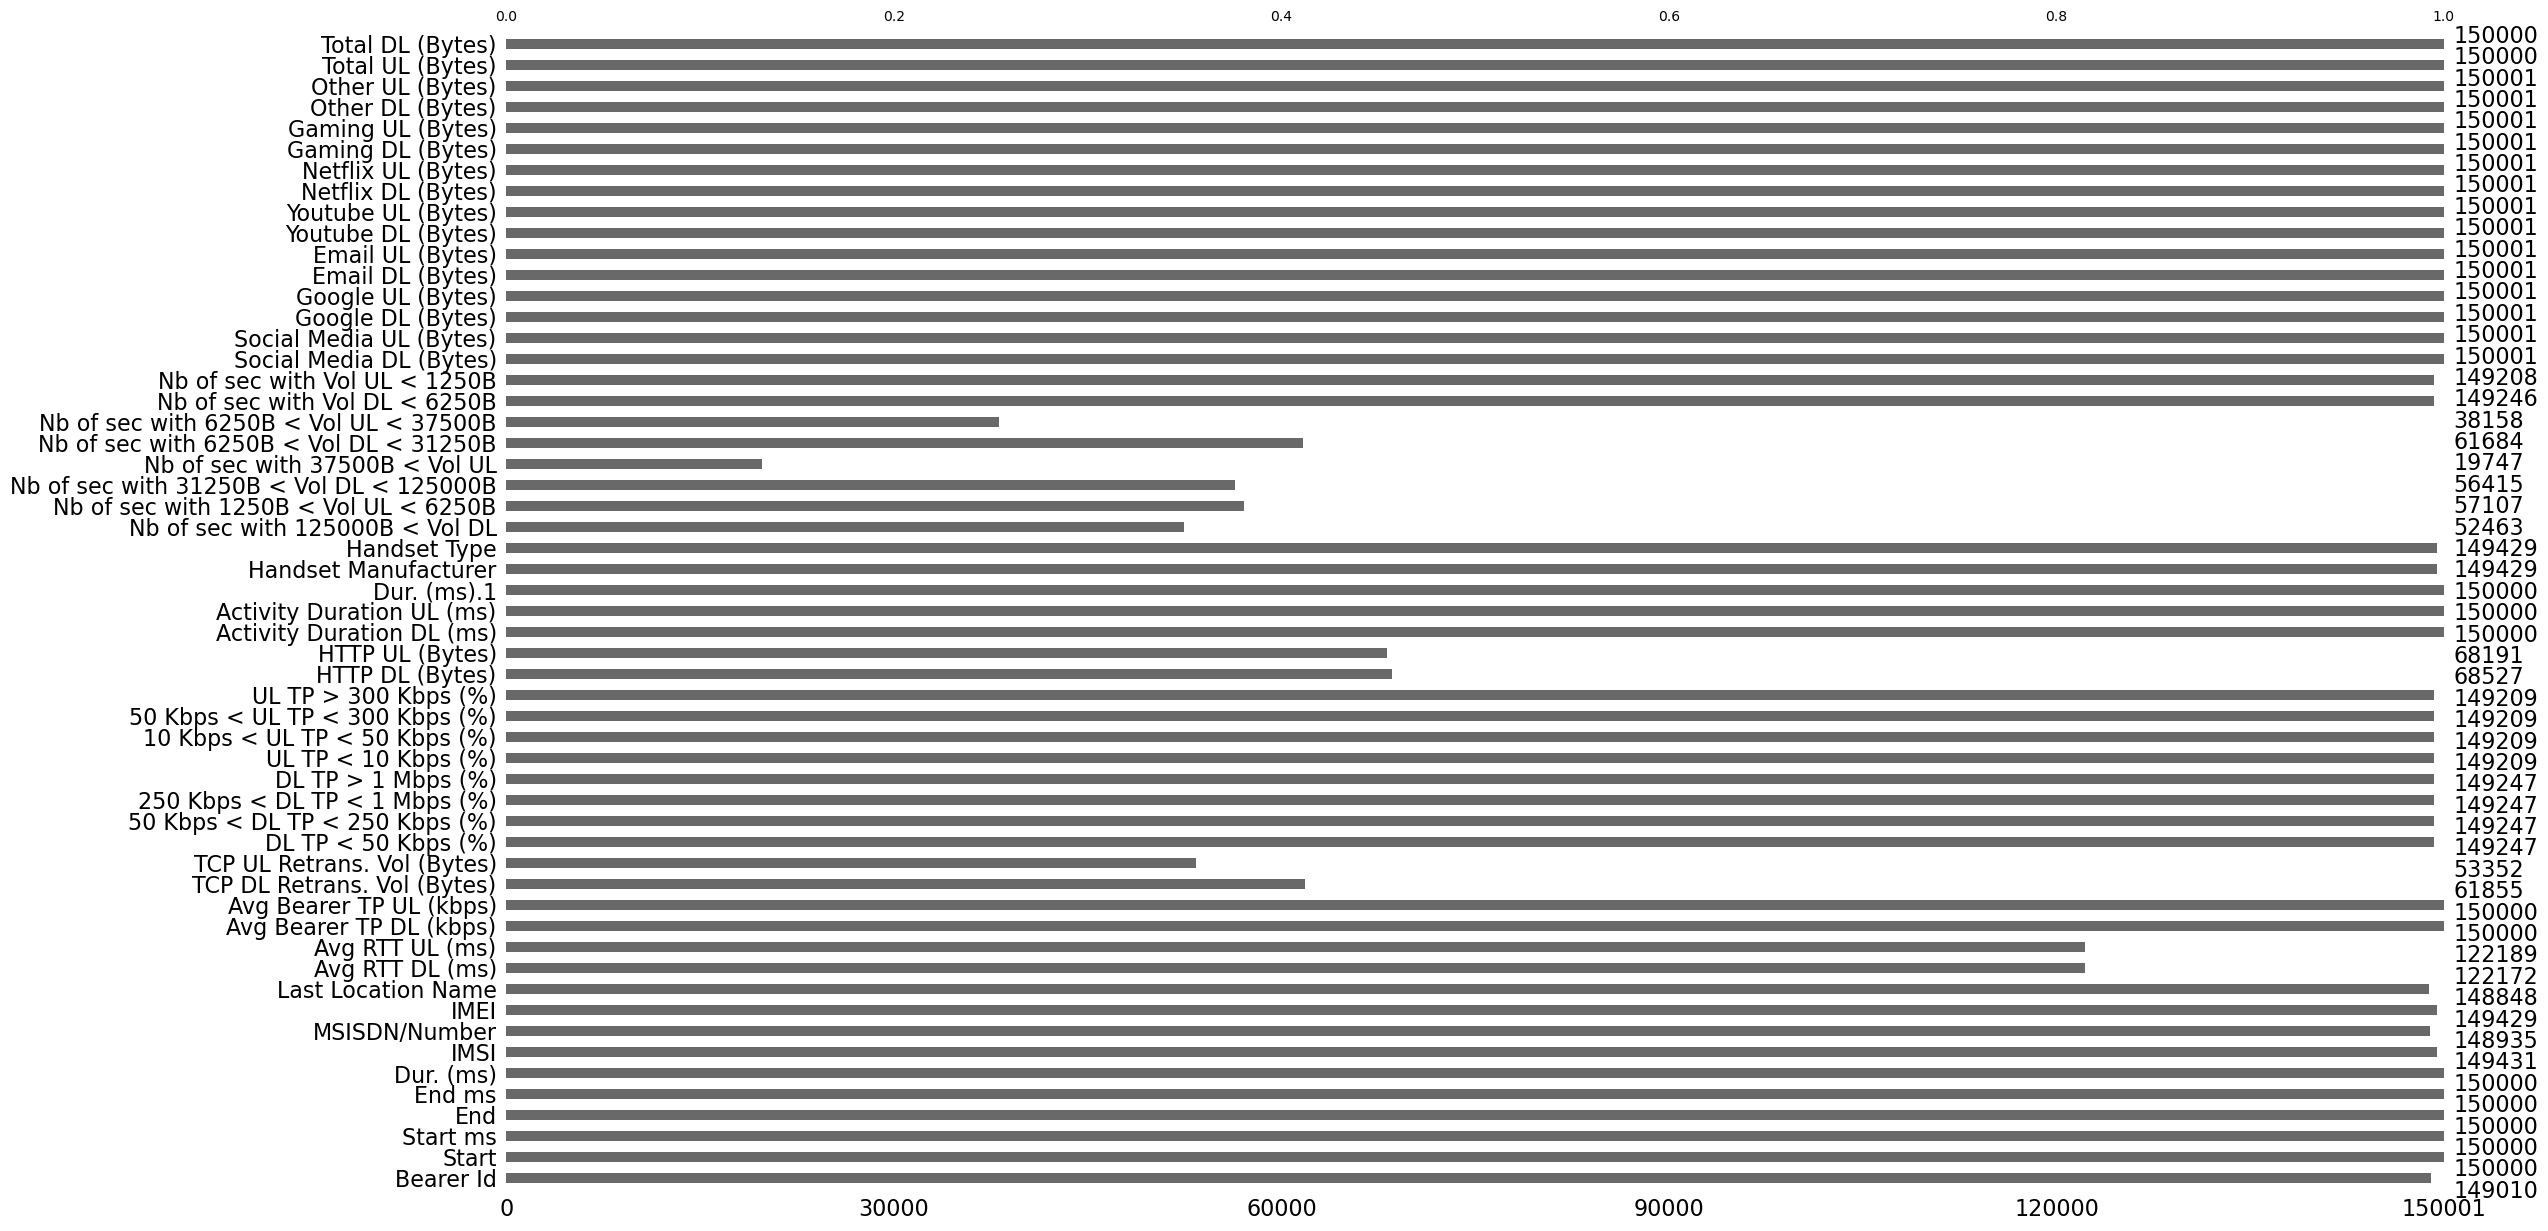

In [11]:
msno.bar(df)

<AxesSubplot:>

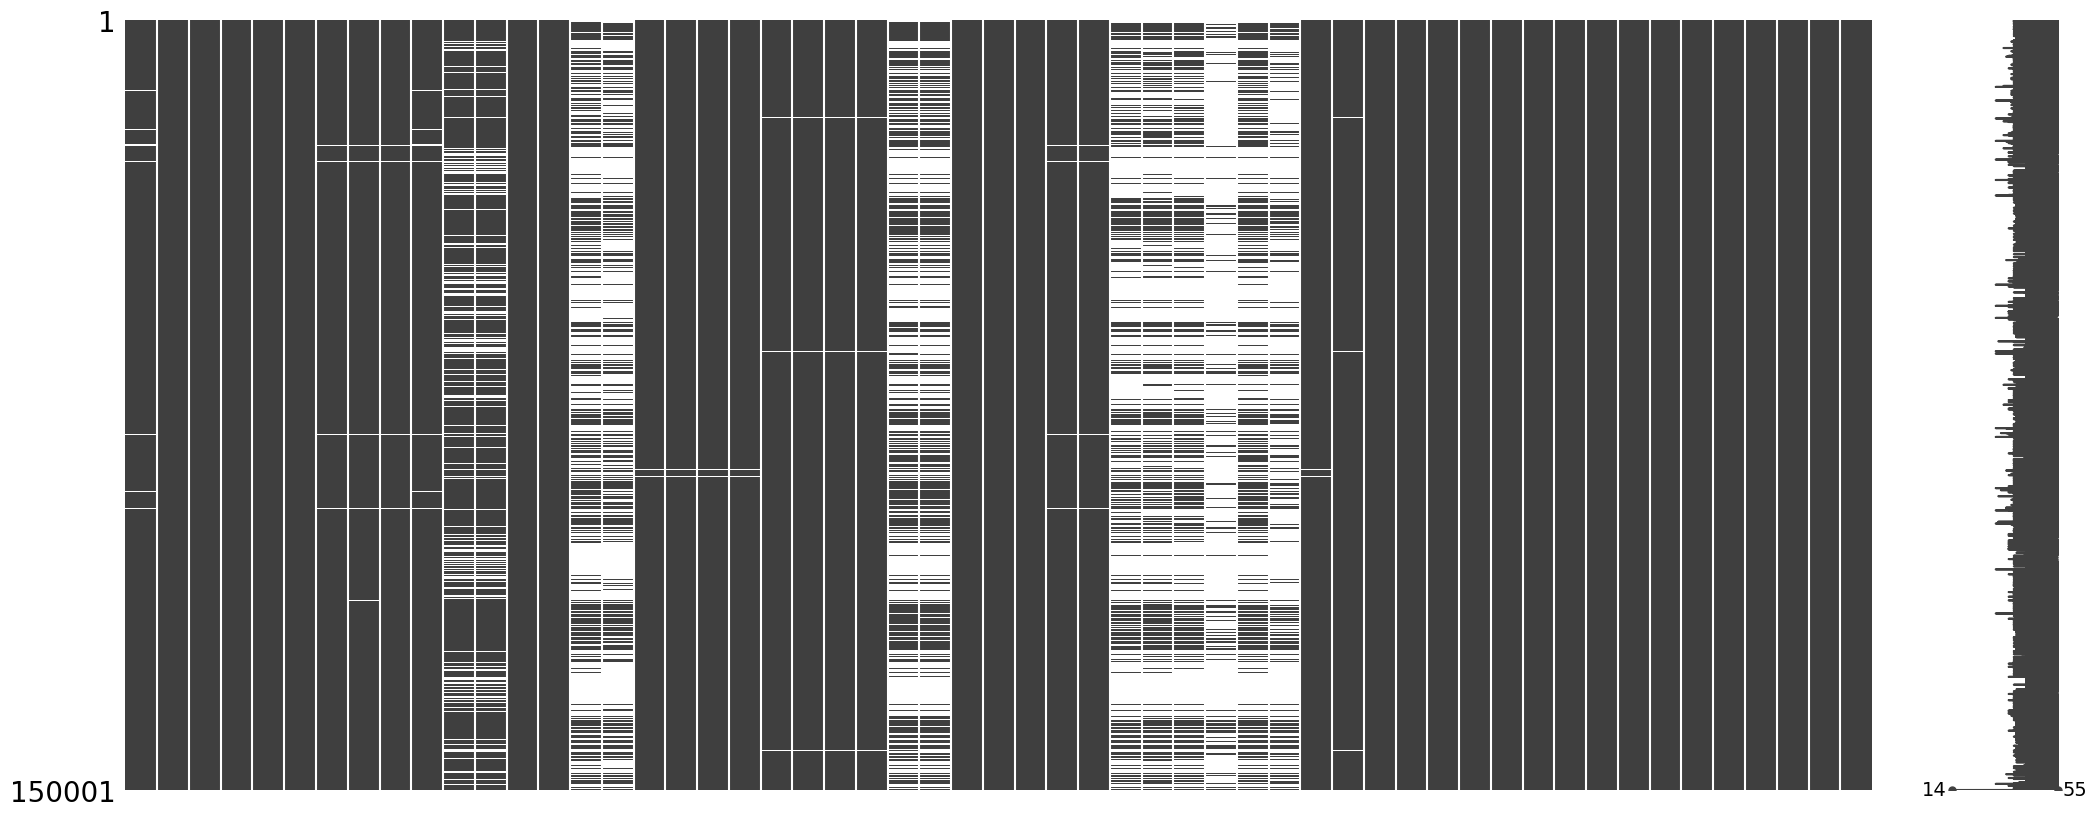

In [12]:
msno.matrix(df)

<AxesSubplot:>

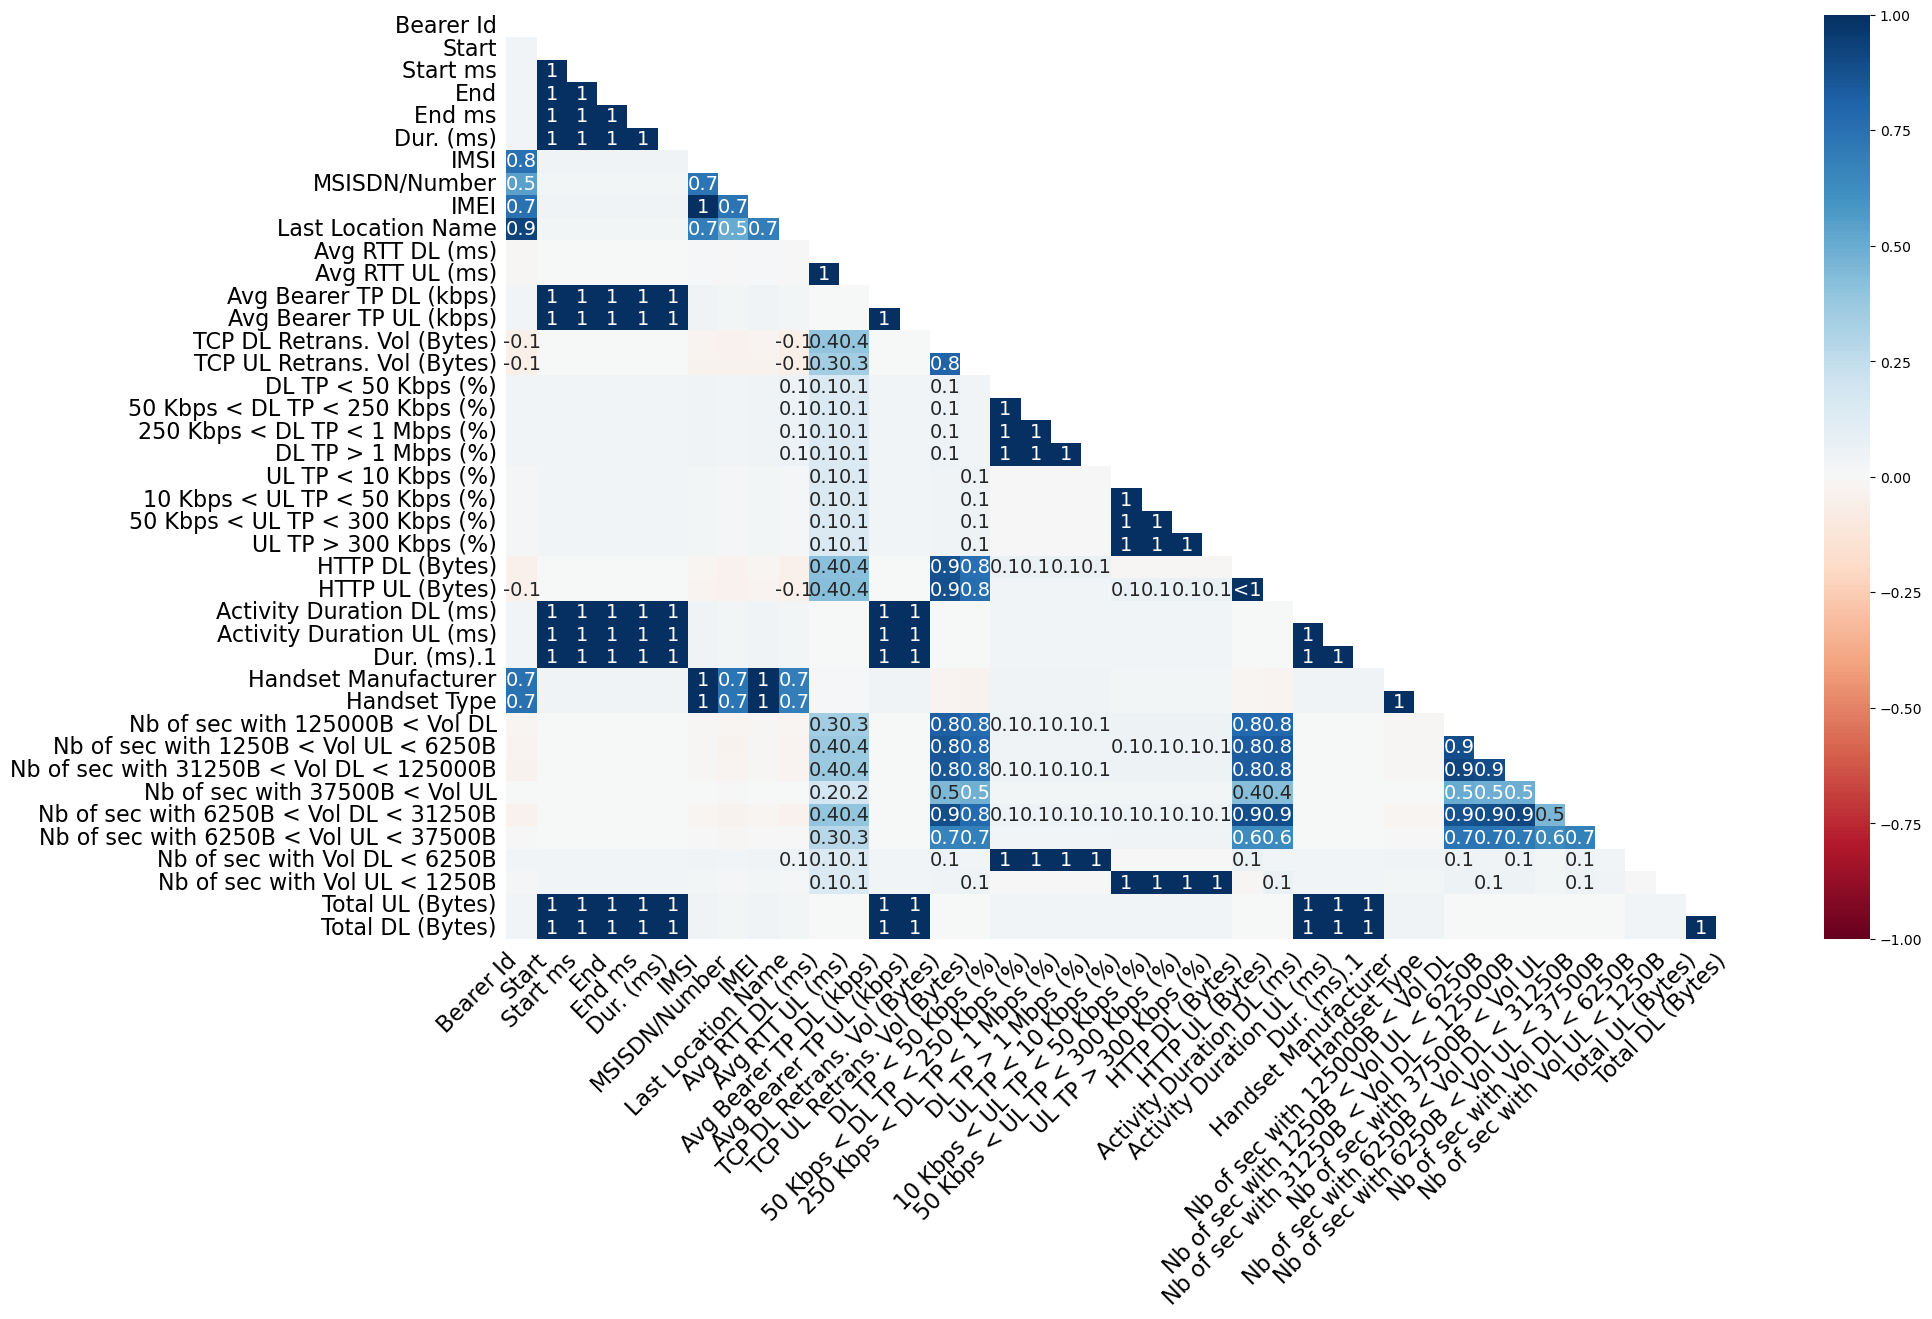

In [13]:
msno.heatmap(df)

<AxesSubplot:>

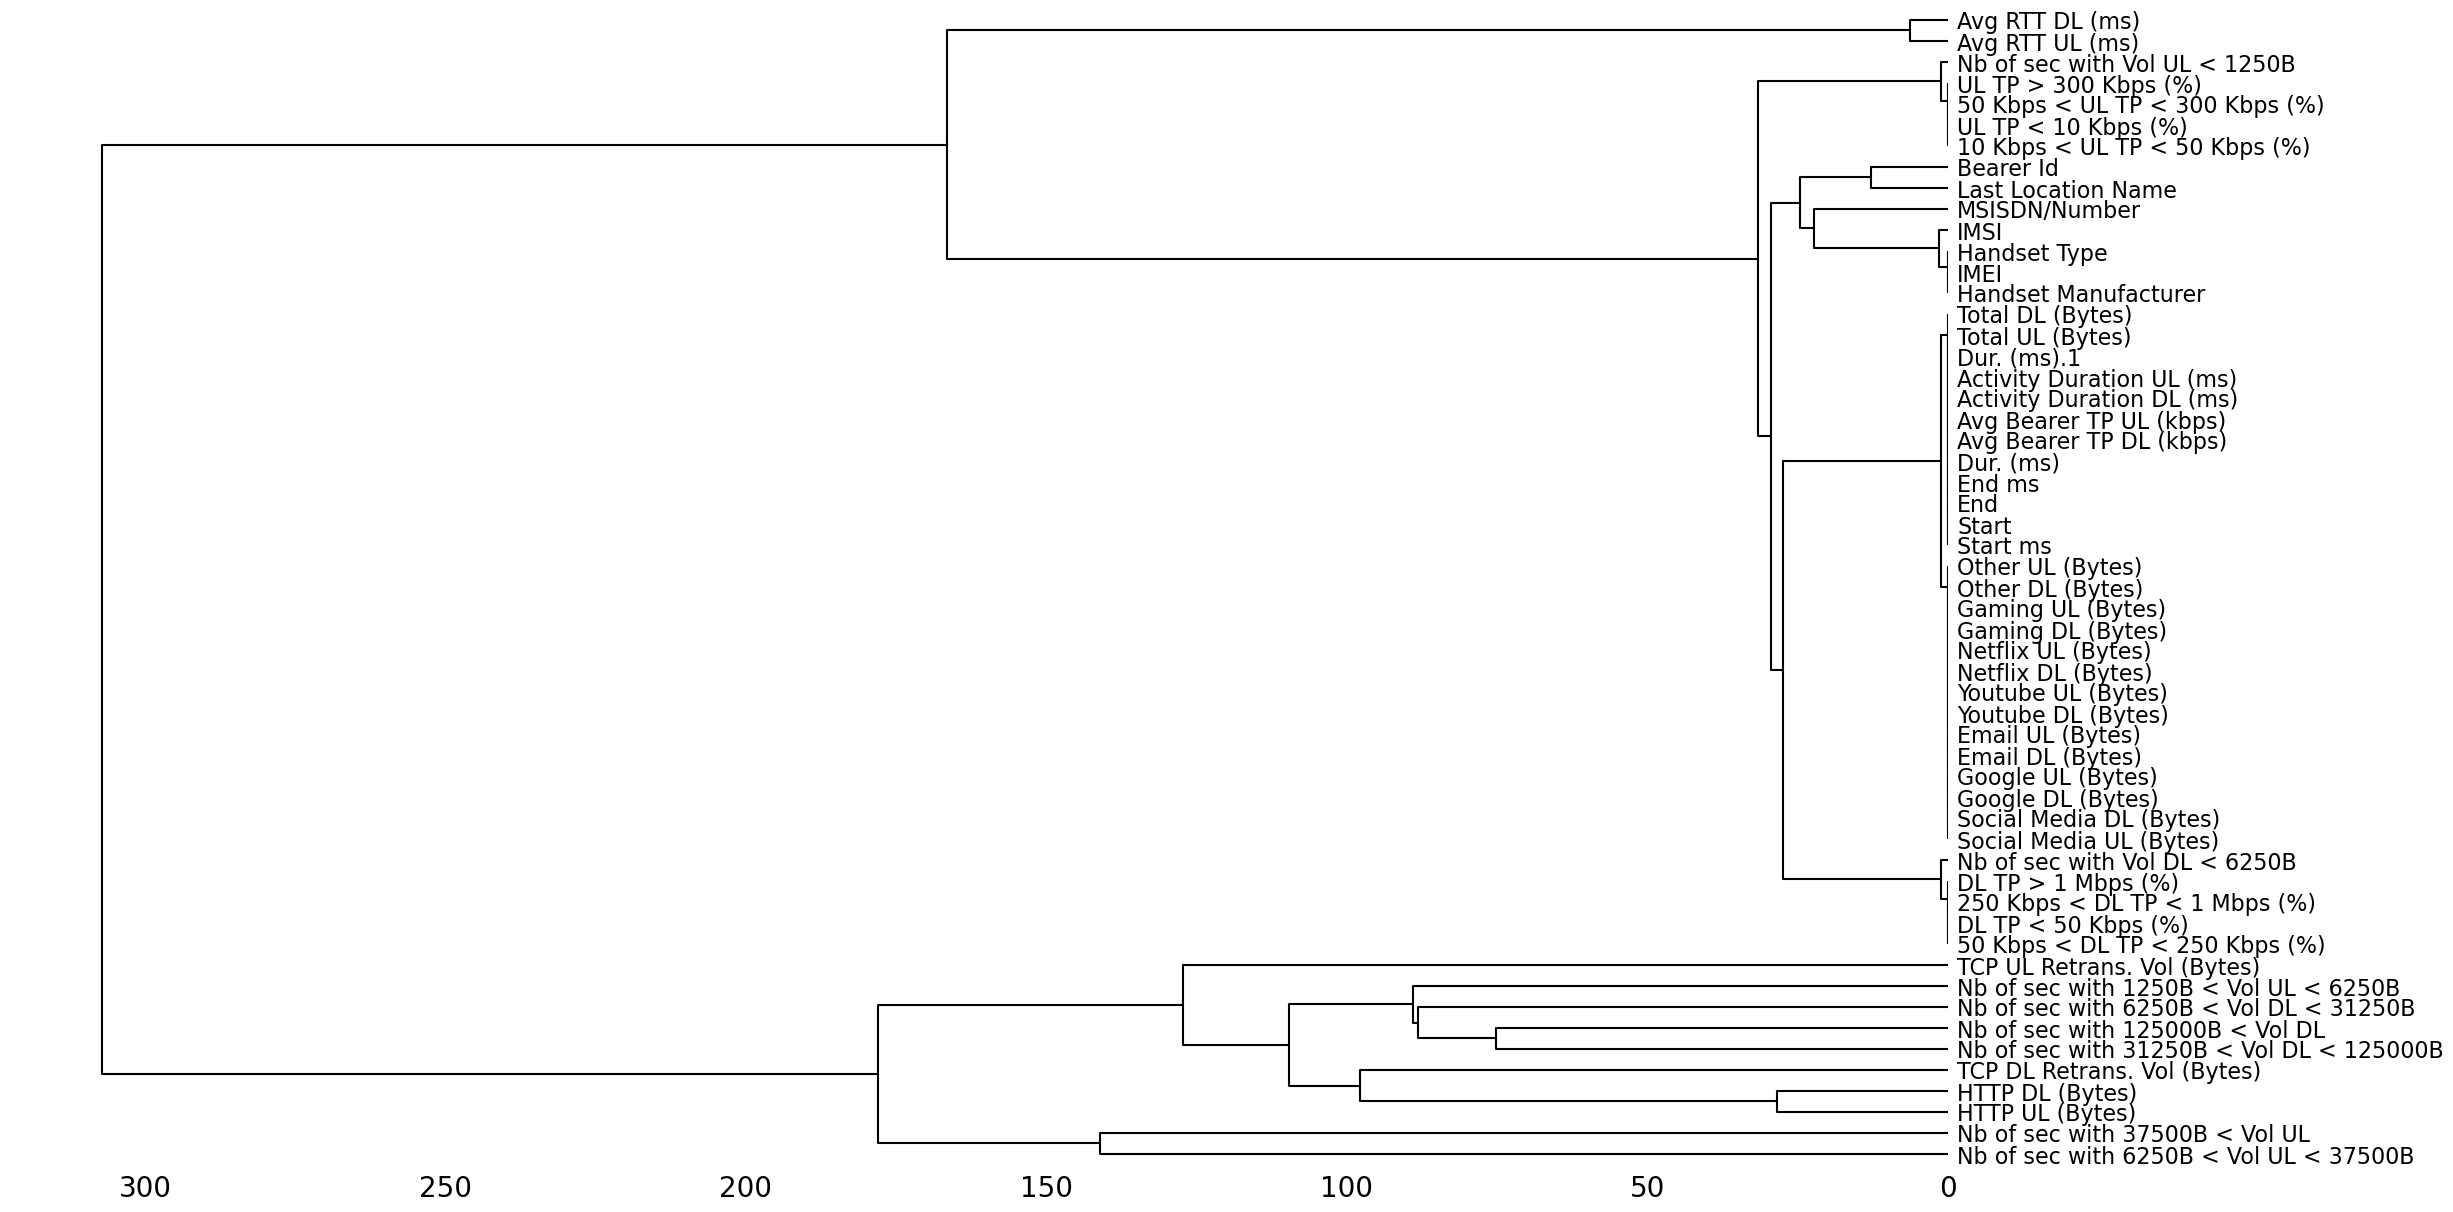

In [14]:
msno.dendrogram(df)

In [15]:
totalCells, missingCount, totalMissing = percent_missing(df)
print("The Telcom dataset contains", round(
    ((totalMissing/totalCells) * 100), 2), "%", "missing values.")

The Telcom dataset contains 12.5 % missing values.


/tmp/ipykernel_3986/2913487394.py:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  totalCells, missingCount, totalMissing = percent_missing(df)


In [16]:
mis_val_table_ren_columns = missing_values_table(df)
mis_val_table_ren_columns

Your selected dataframe has 55 columns.
There are 41 columns that have missing values.


,Missing Values,% of Total Values,Dtype
Nb of sec with 37500B < Vol UL,130254,86.8,float64
Nb of sec with 6250B < Vol UL < 37500B,111843,74.6,float64
Nb of sec with 125000B < Vol DL,97538,65.0,float64
TCP UL Retrans. Vol (Bytes),96649,64.4,float64
Nb of sec with 31250B < Vol DL < 125000B,93586,62.4,float64
Nb of sec with 1250B < Vol UL < 6250B,92894,61.9,float64
Nb of sec with 6250B < Vol DL < 31250B,88317,58.9,float64
TCP DL Retrans. Vol (Bytes),88146,58.8,float64
HTTP UL (Bytes),81810,54.5,float64
HTTP DL (Bytes),81474,54.3,float64


skewness

In [17]:
class MissingInformation:
    def __init__(self,df:pd.DataFrame):
        self.df = df
        logging.basicConfig(filename='../logfile.log', filemode='a',
                            encoding='utf-8', level=logging.DEBUG)
        
    def missing_values_table(self,df:pd.DataFrame)->pd.DataFrame:
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # dtype of missing values
        mis_val_dtype = df.dtypes

        # Make a table with the results
        mis_val_table = pd.concat(
            [mis_val, mis_val_percent, mis_val_dtype], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
            columns={0: 'Missing Values', 1: '% of Total Values', 2: 'Dtype'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
            '% of Total Values', ascending=False).round(1)

        # Print some summary information
     
        logging.info("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
                         "There are " + str(mis_val_table_ren_columns.shape[0]) +
                         " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

    def percent_missing(self,df:pd.DataFrame):

        # Calculate total number of cells in dataframe
        totalCells = np.product(df.shape)

        # Count number of missing values per column
        missingCount = df.isnull().sum()

        # Calculate total number of missing values
        totalMissing = missingCount.sum()

        return totalCells, missingCount, totalMissing

In [18]:
class DataFrameInformation:
    
    def __init__(self,data:pd.DataFrame):
        self.data = data
        logging.basicConfig(filename='../logfile.log', filemode='a',
                            encoding='utf-8', level=logging.DEBUG)
        
    #calculate the skewness of the dataframe first
    def get_skewness(self,data:pd.DataFrame):
        skewness = data.skew(axis=0, skipna=True)
        df_skewness = pd.DataFrame(skewness)
        df_skewness = df_skewness.rename(
            columns={0: 'skewness'})
        
        return df_skewness

    #calculate skewness and missing value table
    def get_skewness_missing_count(self,data:pd.DataFrame):
        df_skewness = self.get_skewness(data)
        minfo = MissingInformation(data)
        
        mis_val_table_ren_columns = minfo.missing_values_table(data)
        df1 = pd.concat([df_skewness, mis_val_table_ren_columns], axis=1)
        df1['Dtype'] = df1['Dtype'].fillna('float64')
        df1['% of Total Values'] = df1['% of Total Values'].fillna(0.0)
        df1['Missing Values'] = df1['Missing Values'].fillna(0)
        df1 = df1.sort_values(by='Missing Values', ascending=False)
        return df1

    def get_column_with_string(self,df: pd.DataFrame, text):
        return [col for col in df.columns if re.findall(text, col) != []]

    def get_dataframe_information(self,df: pd.DataFrame):
        columns = []
        counts = []
        i = 0

        for key, item in df.isnull().sum().items():
            if item != 0:
                columns.append(key)
                counts.append(item)
                i += 1
        logging.info(
            'the dataset contain {} columns with missing values'.format(i))
        return pd.DataFrame({'column name': columns, 'counts': counts})

<AxesSubplot:>

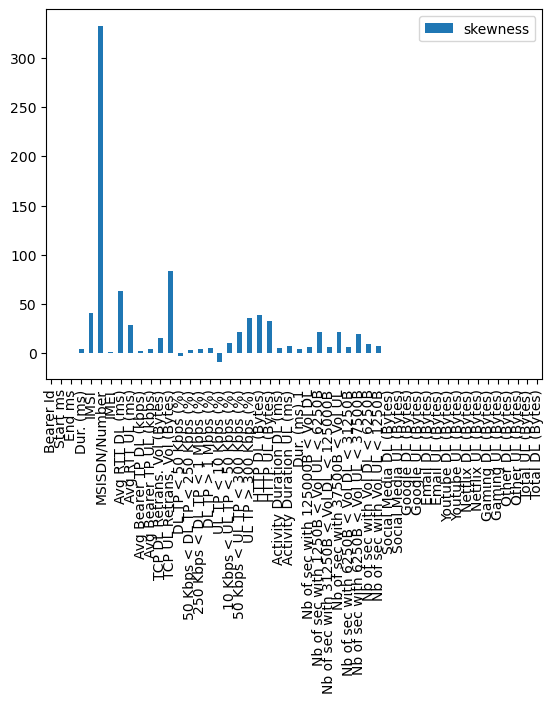

In [19]:
# Exclude non-numeric columns and calculate skewness

numeric_columns = df.select_dtypes(include=np.number)
skewness = numeric_columns.skew(axis=0, skipna=True)

# Create DataFrame to store skewness values
df_skewness = pd.DataFrame({'skewness': skewness})
df_skewness
df_skewness.plot(kind='bar')

In [20]:
d_f = pd.concat([df_skewness, mis_val_table_ren_columns], axis=1)
d_f['Dtype'] = d_f['Dtype'].fillna('float64')
d_f['% of Total Values'] = d_f['% of Total Values'].fillna(0.0)
d_f['Missing Values'] = d_f['Missing Values'].fillna(0)
d_f.sort_values(by='Missing Values', ascending=False)

,skewness,Missing Values,% of Total Values,Dtype
Nb of sec with 37500B < Vol UL,21.560028,130254.0,86.8,float64
Nb of sec with 6250B < Vol UL < 37500B,19.642752,111843.0,74.6,float64
Nb of sec with 125000B < Vol DL,6.592502,97538.0,65.0,float64
TCP UL Retrans. Vol (Bytes),84.113393,96649.0,64.4,float64
Nb of sec with 31250B < Vol DL < 125000B,6.610541,93586.0,62.4,float64
Nb of sec with 1250B < Vol UL < 6250B,22.035745,92894.0,61.9,float64
Nb of sec with 6250B < Vol DL < 31250B,6.896050,88317.0,58.9,float64
TCP DL Retrans. Vol (Bytes),15.951809,88146.0,58.8,float64
HTTP UL (Bytes),32.474970,81810.0,54.5,float64
HTTP DL (Bytes),38.944710,81474.0,54.3,float64


<AxesSubplot:ylabel='Density'>

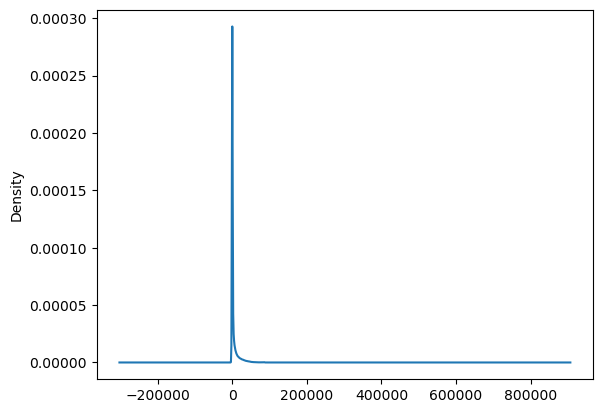

In [21]:

df['Nb of sec with Vol UL < 1250B'].plot(kind='kde')

# Data cleaning 

In [22]:
# identify non missing coloumns
i = 0
for key, item in df.isnull().sum().items():
    if item==0:
        i+=1
        print(key)
print('the dataset contain {} columns with no missing values'.format(i))

Social Media DL (Bytes)
Social Media UL (Bytes)
Google DL (Bytes)
Google UL (Bytes)
Email DL (Bytes)
Email UL (Bytes)
Youtube DL (Bytes)
Youtube UL (Bytes)
Netflix DL (Bytes)
Netflix UL (Bytes)
Gaming DL (Bytes)
Gaming UL (Bytes)
Other DL (Bytes)
Other UL (Bytes)
the dataset contain 14 columns with no missing values


In [23]:
# missing values columns
columns = []
counts=[]
i=0
for key, item in df.isnull().sum().items():
    if item != 0:
        columns.append(key)
        counts.append(item)
        i+=1
print('the dataset contain {} columns with missing values'.format(i))
pd.DataFrame({'column name':columns,'counts':counts})

the dataset contain 41 columns with missing values


,column name,counts
0,Bearer Id,991
1,Start,1
2,Start ms,1
3,End,1
4,End ms,1
5,Dur. (ms),1
6,IMSI,570
7,MSISDN/Number,1066
8,IMEI,572
9,Last Location Name,1153


In [24]:
from scipy.stats.mstats import winsorize
class CleanData:
    def __init__(self,df:pd.DataFrame):
        self.df = df
        logging.basicConfig(filename='../logfile.log', filemode='a',
                            encoding='utf-8', level=logging.DEBUG)
    
    def convert_dtype(self, df: pd.DataFrame, columns, dtype):
        for col in columns:
            df[col] = df[col].astype(dtype=dtype)
        return df
    
    def format_float(self,value):
        return f'{value:,.2f}'

    def convert_bytes_to_megabytes(self, df:pd.DataFrame, columns):

        megabyte = 1*10e+5
        for col in columns:
            df[col] = df[col] / megabyte
        return df
    
    def convert_ms_to_sec(self, df:pd.DataFrame, columns): 
        s = 10e+3
        for col in columns:
            df[col] = df[col] / s
        return df 
    
    def fix_missing_ffill(self, df: pd.DataFrame,col):
        df[col] = df[col].fillna(method='ffill')
        return df[col]
  
    def fix_missing_bfill(self, df: pd.DataFrame, col):
        df[col] = df[col].fillna(method='bfill')
        return df[col]
    
    def drop_column(self, df: pd.DataFrame, columns) -> pd.DataFrame:
        for col in columns:
            df = df.drop([col], axis=1)
        return df

    def drop_missing_count_greaterthan_20p(self,data:pd.DataFrame):
        data_info = DataFrameInformation(data)
        df = data_info.get_skewness_missing_count(data)
        not_fill = df[(df['% of Total Values'] >= 20.0)].index.tolist()
        df_clean = self.drop_column(data, not_fill)
         
        return df_clean
    
    def fill_mode(self, df: pd.DataFrame, columns) -> pd.DataFrame:
        for col in columns:
            df[col] = df[col].fillna(df[col].mode()[0])
        return df

    def fix_outlier(self,df:pd.DataFrame, columns):
        for column in columns:
            df[column] = np.where(df[column] > df[column].quantile(0.95), df[column].median(), df[column])
            
        return df

    def handle_outliers(self, df: pd.DataFrame,lower,upper):
       
        selected_columns = df.select_dtypes(include='float64').columns
        for col in selected_columns:
            df[col] = winsorize(df[col], (lower, upper))
        return df

In [25]:
df_cleaned = df.copy()

data_cleaner = CleanData(df_cleaned)


In [26]:
# assuming a user will hold a phone from the most known brand and most known model. and be at where most of the users are. 
df_cleaned['Handset Manufacturer'] = df_cleaned['Handset Manufacturer'].fillna(
    df_cleaned['Handset Manufacturer'].mode()[0])
df_cleaned['Handset Type'] = df_cleaned['Handset Type'].fillna(
    df_cleaned['Handset Type'].mode()[0])
df_cleaned['Last Location Name'] = df_cleaned['Last Location Name'].fillna(
    df_cleaned['Last Location Name'].mode()[0])

In [27]:
# the missing values in End and start column is only 1. we can replace it with bfill or ffill
df_cleaned['End'] = fix_missing_ffill(df_cleaned, 'End')
df_cleaned['Start'] = fix_missing_ffill(df_cleaned, 'Start')

/home/hp/10academy/10telecom/src/utils.py:79: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill')


In [28]:


#get columns with % of missing value > 30

drop_column = mis_val_table_ren_columns[mis_val_table_ren_columns['% of Total Values']>15].index
print(drop_column.tolist())



['Nb of sec with 37500B < Vol UL', 'Nb of sec with 6250B < Vol UL < 37500B', 'Nb of sec with 125000B < Vol DL', 'TCP UL Retrans. Vol (Bytes)', 'Nb of sec with 31250B < Vol DL < 125000B', 'Nb of sec with 1250B < Vol UL < 6250B', 'Nb of sec with 6250B < Vol DL < 31250B', 'TCP DL Retrans. Vol (Bytes)', 'HTTP UL (Bytes)', 'HTTP DL (Bytes)', 'Avg RTT DL (ms)', 'Avg RTT UL (ms)']


In [29]:
df_cleaned= df.drop(drop_column.tolist(),axis=1)
df_cleaned.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [30]:
df_cleaned['Nb of sec with Vol DL < 6250B'] = fix_missing_bfill(
    df_cleaned, 'Nb of sec with Vol DL < 6250B')

/home/hp/10academy/10telecom/src/utils.py:84: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='bfill')


In [31]:


# Calculate the percentage of missing values for each column
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Filter columns based on conditions related to missing value percentage
fill_mode = missing_percentage[(missing_percentage < 20.0) & (missing_percentage >= 0.4)].index.tolist()
not_fill_mode = ['IMEI', 'IMSI', 'MSISDN/Number']

fill_mode_columns = [x for x in fill_mode if x not in not_fill_mode]



In [32]:
# Check if columns in fill_mode_columns exist in df_clean
columns_to_fill = [col for col in fill_mode_columns if col in df_cleaned.columns]

# Fill missing values in the selected columns
df_cleaned[columns_to_fill] = df_cleaned[columns_to_fill].fillna(df_cleaned[columns_to_fill].mode().iloc[0])

# Alternatively, you can use the fillna method with a specific value:
# df_clean[columns_to_fill] = df_clean[columns_to_fill].fillna(some_value)

# Check the result
print(df_cleaned[columns_to_fill].isnull().sum())  # Ensure no missing values remain in these columns

Bearer Id                         0
Last Location Name                0
DL TP < 50 Kbps (%)               0
50 Kbps < DL TP < 250 Kbps (%)    0
250 Kbps < DL TP < 1 Mbps (%)     0
DL TP > 1 Mbps (%)                0
UL TP < 10 Kbps (%)               0
10 Kbps < UL TP < 50 Kbps (%)     0
50 Kbps < UL TP < 300 Kbps (%)    0
UL TP > 300 Kbps (%)              0
Nb of sec with Vol DL < 6250B     0
Nb of sec with Vol UL < 1250B     0
dtype: int64


In [33]:
def cap_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return series.clip(lower=lower_bound, upper=upper_bound)

In [34]:
missing_info = MissingInformation(df_cleaned)
mis_val_table_after_clean = missing_info.missing_values_table(df_cleaned)
mis_val_table_after_clean

,Missing Values,% of Total Values,Dtype
MSISDN/Number,1066,0.7,float64
Handset Type,572,0.4,object
Handset Manufacturer,572,0.4,object
IMEI,572,0.4,float64
IMSI,570,0.4,float64
Start,1,0.0,object
Activity Duration DL (ms),1,0.0,float64
Total UL (Bytes),1,0.0,float64
Dur. (ms).1,1,0.0,float64
Activity Duration UL (ms),1,0.0,float64


In [35]:


df_cleaned.dropna(inplace=True)
mis_val_table_after_clean = missing_info.missing_values_table(df_cleaned)
mis_val_table_after_clean



,Missing Values,% of Total Values,Dtype


In [36]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148935 entries, 0 to 149999
Data columns (total 43 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Bearer Id                       148935 non-null  float64
 1   Start                           148935 non-null  object 
 2   Start ms                        148935 non-null  float64
 3   End                             148935 non-null  object 
 4   End ms                          148935 non-null  float64
 5   Dur. (ms)                       148935 non-null  float64
 6   IMSI                            148935 non-null  float64
 7   MSISDN/Number                   148935 non-null  float64
 8   IMEI                            148935 non-null  float64
 9   Last Location Name              148935 non-null  object 
 10  Avg Bearer TP DL (kbps)         148935 non-null  float64
 11  Avg Bearer TP UL (kbps)         148935 non-null  float64
 12  DL TP < 50 Kbps (%)  

In [37]:
df_cleaned.shape

(148935, 43)

# EDA 


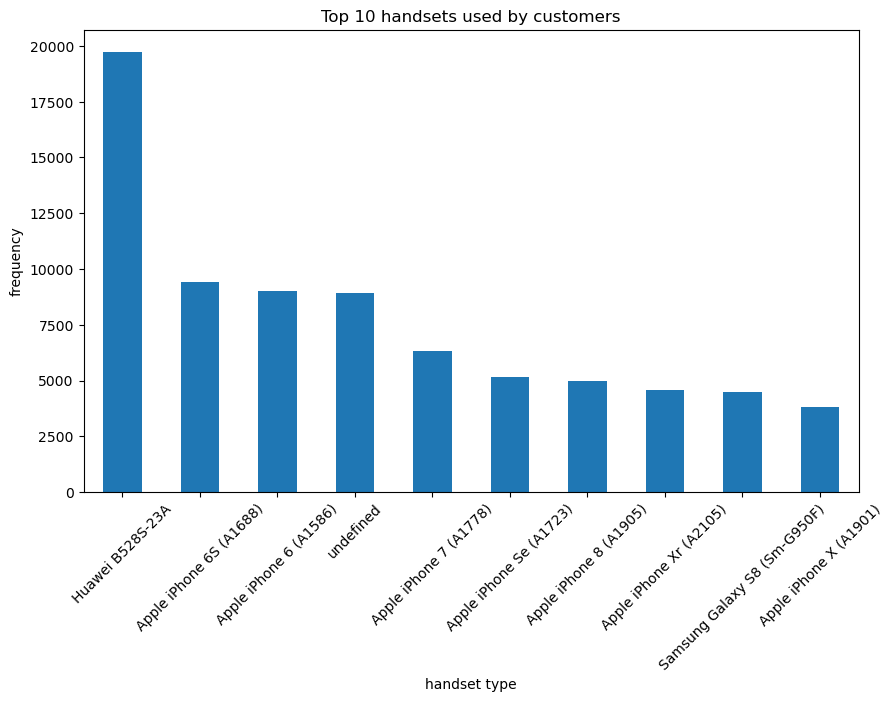

In [38]:
# the top 10 handset used by customers 
# Check for null values in the 'HandsetManufacturer' column


handset_counts = df_cleaned['Handset Type'].value_counts()

sorted_handsets = handset_counts.sort_values(ascending=False)

top_10_handsets = sorted_handsets.head(10)


#create a bar plot 

plt.figure(figsize=(10,6))
top_10_handsets.plot(kind='bar')
plt.title('Top 10 handsets used by customers')
plt.xlabel('handset type')
plt.ylabel('frequency')
plt.xticks(rotation=45)
plt.show()

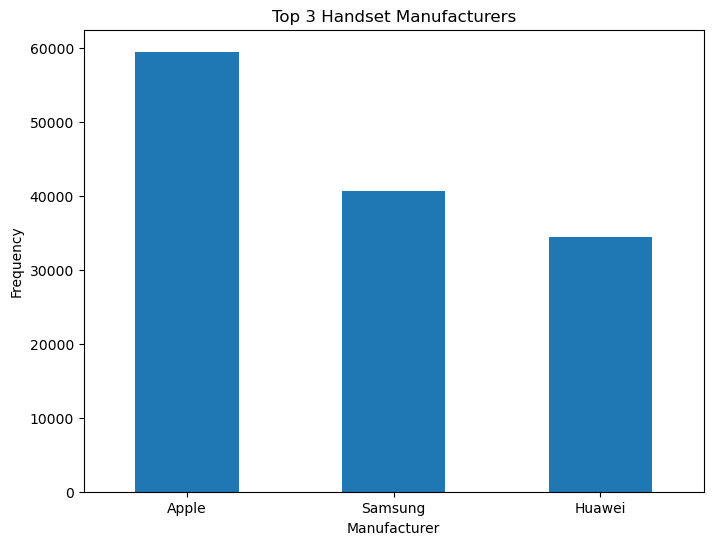

In [39]:
# Check for null values in the 'HandsetManufacturer' column


# Get the value counts for handset manufacturers
manu_counts = df_cleaned['Handset Manufacturer'].value_counts()

# Select the top 3 manufacturers
top_3_manufacturers = manu_counts.head(3)

# Plotting the top 3 manufacturers
plt.figure(figsize=(8,6))
top_3_manufacturers.plot(kind='bar')
plt.title('Top 3 Handset Manufacturers')
plt.xlabel('Manufacturer')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

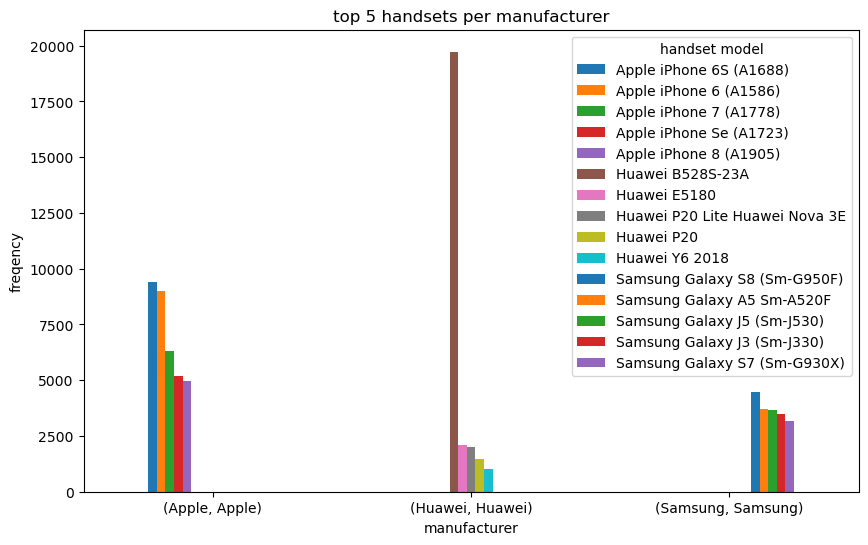

In [40]:
# the top 5 handsets for each of the top 3 handset manufacturer

# Check for null values in the 'HandsetManufacturer' column



manufacturer_counts = df_cleaned['Handset Manufacturer'].value_counts()

top_3_manufacturers = manufacturer_counts.head(3).index

filtered_df = df_cleaned[df_cleaned['Handset Manufacturer'].isin(top_3_manufacturers)]

handset_counts = filtered_df.groupby(['Handset Manufacturer','Handset Type']).size()

top_5_handsets = handset_counts.groupby('Handset Manufacturer').nlargest(5)


top_5_handsets.unstack().plot(kind='bar', figsize=(10,6))
plt.title('top 5 handsets per manufacturer')
plt.xlabel('manufacturer')
plt.ylabel('freqency')
plt.xticks(rotation=0)
plt.legend(title = 'handset model')
plt.show()

<AxesSubplot:xlabel='Handset Manufacturer,Handset Type'>

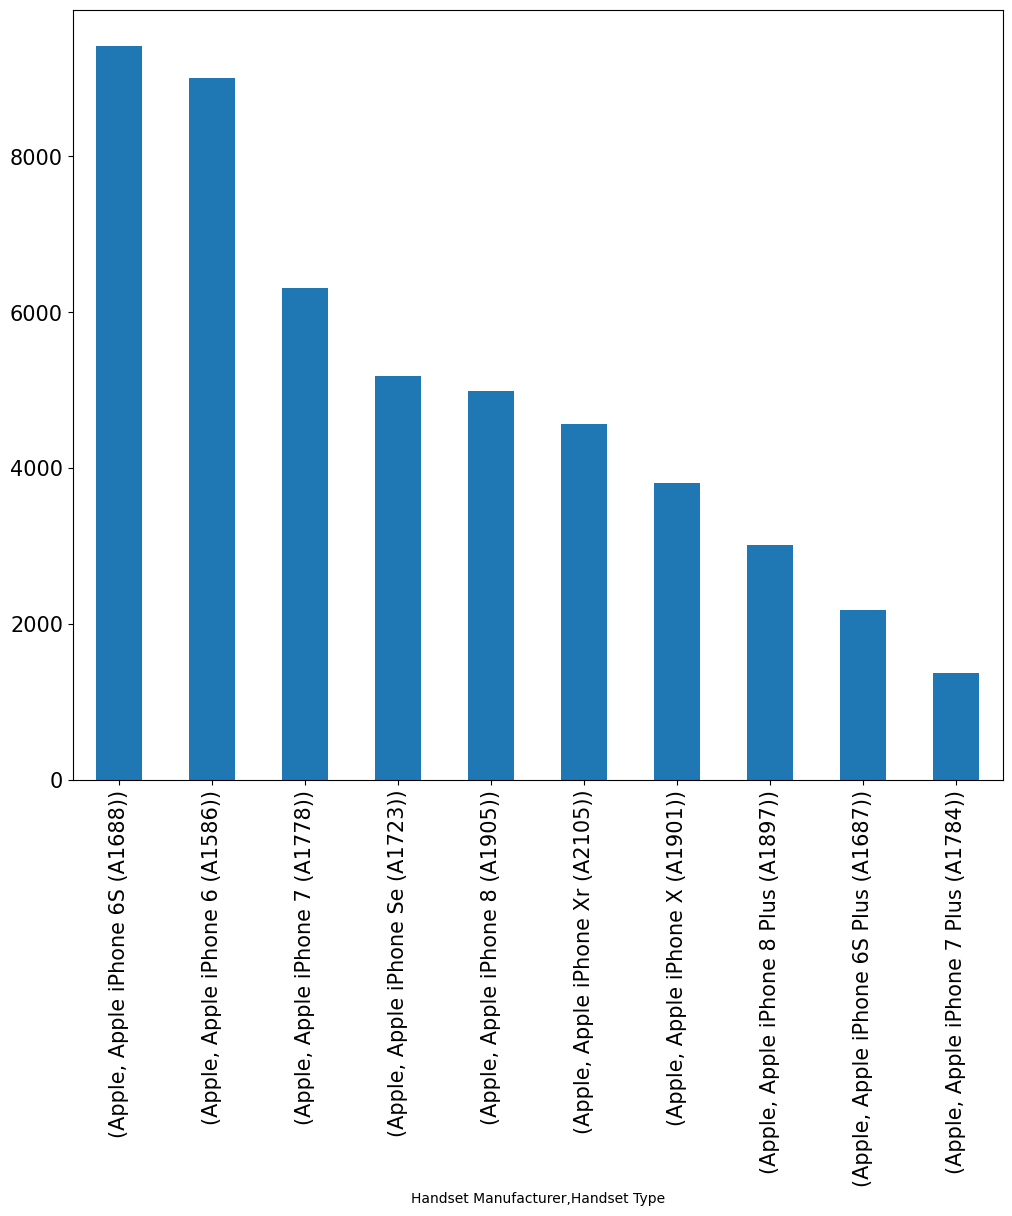

In [41]:
handset_man= df_cleaned[df_cleaned['Handset Manufacturer'].isin(['Apple','Sumsung','Huawei'])]
handset_man.groupby('Handset Manufacturer')['Handset Type'].value_counts()[:10].plot.bar(
    figsize=(12, 10), fontsize=15)

In [42]:
# to aggregate per user information

#aggregate per user information 
aggregated_data = df_cleaned.groupby('MSISDN/Number').agg({
    'Dur. (ms)': 'count',  # Counting the number of sessions
    'Dur. (ms)': 'sum',  # Total session duration
    'Total UL (Bytes)': 'sum',
    'Total DL (Bytes)': 'sum',
    'Social Media DL (Bytes)': 'sum',
    'Social Media UL (Bytes)': 'sum',
    'Google DL (Bytes)': 'sum',
    'Google UL (Bytes)': 'sum',
    'Email DL (Bytes)': 'sum',
    'Email UL (Bytes)': 'sum',
    'Youtube DL (Bytes)': 'sum',
    'Youtube UL (Bytes)': 'sum',
    'Netflix DL (Bytes)': 'sum',
    'Netflix UL (Bytes)': 'sum',
    'Gaming DL (Bytes)': 'sum',
    'Gaming UL (Bytes)': 'sum',
    'Other DL (Bytes)': 'sum',
    'Other UL (Bytes)': 'sum'
}).reset_index()
aggregated_data.head()  # Display the first few rows



,MSISDN/Number,Dur. (ms),Total UL (Bytes),Total DL (Bytes),Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes)
0,3.360100e+10,116720.0,36053108.0,8.426375e+08,2206504.0,25631.0,3337123.0,1051882.0,837400.0,493962.0,14900201.0,6724347.0,10265105.0,16915876.0,8.110911e+08,1367528.0,377096990.0,9473882.0
1,3.360100e+10,181230.0,36104459.0,1.207552e+08,2598548.0,62017.0,4197697.0,1137166.0,2828821.0,478960.0,5324251.0,7107972.0,770569.0,10451194.0,1.050353e+08,14714780.0,279557701.0,2152370.0
2,3.360100e+10,134969.0,39306820.0,5.566597e+08,3148004.0,47619.0,3343483.0,99643.0,2436500.0,768880.0,2137272.0,19196298.0,16525919.0,2827981.0,5.290685e+08,9759228.0,495086501.0,6607171.0
3,3.360101e+10,49878.0,20327526.0,4.019932e+08,251469.0,28825.0,5937765.0,3740728.0,2178618.0,106052.0,4393123.0,2584198.0,1157362.0,784730.0,3.880748e+08,3051292.0,25248001.0,10031701.0
4,3.360101e+10,37104.0,94280527.0,1.363130e+09,2861230.0,51312.0,13728668.0,4770948.0,2247808.0,1057661.0,10339971.0,31193031.0,24971647.0,24230077.0,1.308981e+09,5816727.0,777643713.0,27160771.0


In [43]:
# Dispersion parameters for quantitative variables
dispersion_params = df_cleaned[['Total UL (Bytes)', 'Total DL (Bytes)', 'Social Media DL (Bytes)', 
                          'Google DL (Bytes)', 'Email DL (Bytes)', 'Youtube DL (Bytes)',
                          'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)']].std()
dispersion_params

Total UL (Bytes)           1.127933e+07
Total DL (Bytes)           2.441528e+08
Social Media DL (Bytes)    1.035458e+06
Google DL (Bytes)          3.309041e+06
Email DL (Bytes)           1.035910e+06
Youtube DL (Bytes)         6.711384e+06
Netflix DL (Bytes)         6.724686e+06
Gaming DL (Bytes)          2.439763e+08
Other DL (Bytes)           2.431970e+08
dtype: float64

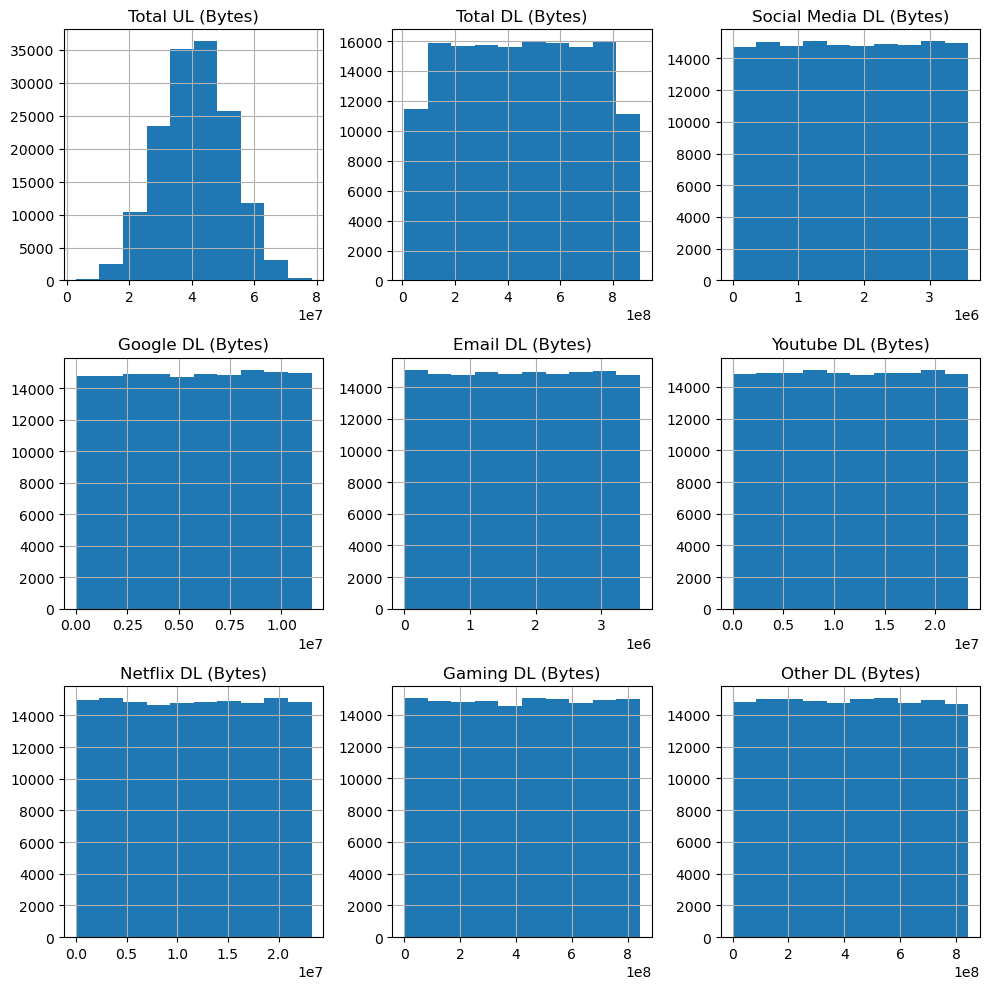

In [44]:
df_cleaned[['Total UL (Bytes)', 'Total DL (Bytes)', 'Social Media DL (Bytes)', 
      'Google DL (Bytes)', 'Email DL (Bytes)', 'Youtube DL (Bytes)',
      'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)']].hist(figsize=(10, 10))
plt.tight_layout()
plt.show()

In [45]:
# Relationship between each application and total DL+UL data
app_vs_total_data = df_cleaned[['Total UL (Bytes)', 'Total DL (Bytes)', 'Social Media DL (Bytes)', 
                          'Google DL (Bytes)', 'Email DL (Bytes)', 'Youtube DL (Bytes)',
                          'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)']].corr()
app_vs_total_data

,Total UL (Bytes),Total DL (Bytes),Social Media DL (Bytes),Google DL (Bytes),Email DL (Bytes),Youtube DL (Bytes),Netflix DL (Bytes),Gaming DL (Bytes),Other DL (Bytes)
Total UL (Bytes),1.000000,-0.002273,0.005040,-0.001432,-0.002119,-0.000326,-0.000454,-0.002247,-0.001711
Total DL (Bytes),-0.002273,1.000000,0.005475,0.012254,0.004406,0.025748,0.024531,0.999131,-0.002822
Social Media DL (Bytes),0.005040,0.005475,1.000000,-0.002071,0.004902,-0.001181,-0.001498,0.001316,0.005903
Google DL (Bytes),-0.001432,0.012254,-0.002071,1.000000,0.000009,0.002076,0.000962,-0.001375,-0.002596
Email DL (Bytes),-0.002119,0.004406,0.004902,0.000009,1.000000,0.001475,0.001168,0.000069,-0.000251
Youtube DL (Bytes),-0.000326,0.025748,-0.001181,0.002076,0.001475,1.000000,0.001026,-0.001799,0.001958
Netflix DL (Bytes),-0.000454,0.024531,-0.001498,0.000962,0.001168,0.001026,1.000000,-0.003054,-0.005690
Gaming DL (Bytes),-0.002247,0.999131,0.001316,-0.001375,0.000069,-0.001799,-0.003054,1.000000,-0.002710
Other DL (Bytes),-0.001711,-0.002822,0.005903,-0.002596,-0.000251,0.001958,-0.005690,-0.002710,1.000000


In [46]:
# variable transformation
# Segment users into deciles based on total session duration
df_cleaned['Total_Session_duration'] = df_cleaned['Dur. (ms)'].groupby(df_cleaned['MSISDN/Number']).transform('sum')
df_cleaned['Decile_Class'] = pd.qcut(df_cleaned['Total_Session_duration'], q=5, labels=False)

# Compute total data (DL+UL) per decile class
total_data_per_decile = df_cleaned.groupby('Decile_Class')[['Total UL (Bytes)', 'Total DL (Bytes)']].sum()
total_data_per_decile

,Total UL (Bytes),Total DL (Bytes)
Decile_Class,,
0,1.224447e+12,1.354009e+13
1,1.227024e+12,1.357136e+13
2,1.304259e+12,1.444640e+13
3,1.144745e+12,1.265695e+13
4,1.223381e+12,1.349479e+13


In [47]:
# Correlation matrix
correlation_matrix = df_cleaned[['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)', 
                           'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 
                           'Other DL (Bytes)']].corr()
correlation_matrix

,Social Media DL (Bytes),Google DL (Bytes),Email DL (Bytes),Youtube DL (Bytes),Netflix DL (Bytes),Gaming DL (Bytes),Other DL (Bytes)
Social Media DL (Bytes),1.000000,-0.002071,0.004902,-0.001181,-0.001498,0.001316,0.005903
Google DL (Bytes),-0.002071,1.000000,0.000009,0.002076,0.000962,-0.001375,-0.002596
Email DL (Bytes),0.004902,0.000009,1.000000,0.001475,0.001168,0.000069,-0.000251
Youtube DL (Bytes),-0.001181,0.002076,0.001475,1.000000,0.001026,-0.001799,0.001958
Netflix DL (Bytes),-0.001498,0.000962,0.001168,0.001026,1.000000,-0.003054,-0.005690
Gaming DL (Bytes),0.001316,-0.001375,0.000069,-0.001799,-0.003054,1.000000,-0.002710
Other DL (Bytes),0.005903,-0.002596,-0.000251,0.001958,-0.005690,-0.002710,1.000000


In [48]:
# Dimensionality Reduction (Principal Component Analysis - PCA


# Select relevant columns for PCA
pca_data = df_cleaned[['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)', 
                 'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 
                 'Other DL (Bytes)']]

# Standardize the data
pca_data_standardized = (pca_data - pca_data.mean()) / pca_data.std()

# Perform PCA
pca = PCA(n_components=2)
pca.fit(pca_data_standardized)

# Extract principal components
components = pca.components_
explained_variance = pca.explained_variance_ratio_

print("Principal Components:")
print(components)
print("Explained Variance Ratio:")
print(explained_variance)

Principal Components:
[[-0.56003388  0.31645188 -0.19146796  0.0477651   0.43720385 -0.09574137
  -0.58903748]
 [-0.17268395 -0.26672742 -0.4008746  -0.55019124 -0.3091343   0.54355042
  -0.2112222 ]]
Explained Variance Ratio:
[0.14436429 0.14354523]
